# Lab 2: Stochastic Gradient Descent

`python 2.7`

The goal of this lab session is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

You have to send the filled notebook named **"L2_familyname1_familyname2.ipynb"** by email to *violeta.roizman@l2s.centralesupelec.fr* by October 10, 2018. Please put **"AML-L2"** in the subject. 

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys
import random

## Loading dataset

We are going to use the W8A dataset, a tidy and binarized version of https://archive.ics.uci.edu/ml/datasets/adult (check it out for more details). 
In this dataset we have census data to predict if the income of an adult exceeds $50K/yr (1 or -1).  

In [2]:
w8a_train = pd.read_csv("w8a.csv", sep=";")
w8a_train_x = w8a_train.iloc[:, :-1]
w8a_train_y = w8a_train.iloc[:, -1]

w8a_test  = pd.read_csv("w8a_t.csv", sep=";")
w8a_test_x = w8a_test.iloc[:, :-1]
w8a_test_y = w8a_test.iloc[:, -1]

print w8a_train.info()
w8a_train.sample(n=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49748 entries, 0 to 49747
Columns: 301 entries, 0.0 to -1
dtypes: float64(300), int64(1)
memory usage: 114.2 MB
None


,0.0,0.0.1,0.0.2,0.0.3,0.0.4,0.0.5,0.0.6,0.0.7,0.0.8,0.0.9,...,0.0.287,0.0.288,0.0.289,0.0.290,0.0.291,0.0.292,0.0.293,0.0.294,0.0.295,-1
33995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
44644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
49506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
19066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
9454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1


## Logistic Regression



Today weâ€™ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label. 

Hence, $$ \nabla L(\textbf{w}) =  \nabla F(\textbf{w}) + \nabla R(\textbf{w}) = \sum_{i=1}^{n}\frac{-y_{i}e^{-y_{i}\textbf{w}^{T}\textbf{x}_{i}}}{1+e^{-y_{i}\textbf{w}^{T}\textbf{x}_{i}}} + \lambda\textbf{w}$$


### Sklearn implementation

We first use the `sklearn` implementation:

In [3]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=1.0)
model.fit(w8a_train_x, w8a_train_y)
y_pred = model.predict(w8a_test_x)

and we compute the accuracy score to evaluate the model performance:

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(w8a_test_y, y_pred)

0.985685618729097

### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent. 

- Fill in the classes

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

For a given batch $\mathcal{B_{t}}$, $$ \beta^{(t+1)} = \beta^{(t)} - \gamma_{t}\nabla_{\beta}{L_{\mathcal{B_{t}}}(\beta^{(t)})}$$

Where $$L_{\mathcal{B_{t}}}(\textbf{w}) = \frac{1}{|\mathcal{B}_{t}|}\sum_{(x, y)\in\mathcal{B_{t}}}{log(1+\exp(-y\textbf{w}^Tx))+\frac{\lambda}{2} \| \textbf{w} \|^2}$$

At each iteration, the loop basically goes :

__Iteration `t` over `nr_iter`__
> **(a)** Generate random batch $\mathcal{B}_{t}=\{(X_{i}, y_{i})\}$ of size `bsize`

> **(b)** Compute $L_{\mathcal{B_{t}}}(\beta^{(t-1)})$ (`f`) and $\nabla L_{\mathcal{B_{t}}}(\beta^{(t-1)})$ (`fprime`)

> **(c)** Compute $\beta^{(t)}$ out of $\beta^{(t-1)}$ following the `acceleration` strategy

> **(d)** Store $L_{\mathcal{B_{t}}}, \nabla L_{\mathcal{B_{t}}}$ and $\beta^{(t)}$ if needed

Step **(c)** differs from an acceleration strategy to the other :

> - `none` : $$ \beta^{(t+1)} = \beta^{(t)} - \gamma\nabla_{\beta}{L_{\mathcal{B_{t}}}(\beta^{(t)})} $$

> - `momentum` : $$ \beta^{(t+1)} = \beta^{(t)} - \gamma\nabla_{\beta}{L_{\mathcal{B_{t}}}(\beta^{(t)})} + \theta(\beta^{(t)}-\beta^{(t-1)})$$

> - `adagrad` : If $ G_{t} = (\nabla_{\beta}L_{\mathcal{B_{i}}}(\beta^{(i)}))_{i\in\{1,...,t\}} $ and $W_{t} = diag(\{[G_{t}]_{i,i}^{T}[G_{t}]_{i,i}, i\in\{1,...,t\}\})$

In [5]:
def sgd(X, y, bsize, lr, f, fprime, beta, alpha, nr_iter=100, acceleration="none", momentum=0.5):
    """Use the stochastic gradient descent optimiser to optimise f.        
    Parameters:
    -----------
    X: numpy.array
        features set
    y: numpy.array
        labels set
    bsize: int
        batch size
    f: function
        loss function to optimize
    fprime: funtion
        gradient of f following beta
    beta: numpy.array
        weights vector
    nr_iter: int
        number of iterations
    acceleration: string
        name of the acceleration strategy
    """
    f_history = []
    fprime_history = []
    beta_history = []
    
    # For SAG and SAGA, we need to preset the batches to maintain a table with all
    # theta values needed in acceleration strategy
    if acceleration.lower()[:3] == "sag":
        
        # initialize theta values out of beta intialization
        theta = [np.copy(beta)]*nr_iter
        
        # generate all random batches at once
        batch_idxs = [random.sample(np.arange(len(X)), k=bsize) for i in range(nr_iter)]
        
        # compute gradient at theta for each batch
        fprime_theta_history = [fprime(t, X[idx], y[idx], alpha) for t, idx in zip(theta, batch_idxs)]
        
        # iterate over beta using the precomputed theta table
        for i, idx in enumerate(batch_idxs):
            
            # Extract samples and their labels from specified indexes
            X_batch = X[idx]
            y_batch = y[idx]

            # Compute cost function
            f_batch = f(beta, X_batch, y_batch, alpha)

            # Compute gradient
            fprime_batch = fprime(beta, X_batch, y_batch, alpha)
            fprime_theta = fprime(theta[i], X_batch, y_batch, alpha)
            
            if acceleration.lower() == "sag":
                beta = beta - lr*((fprime_batch-fprime_theta)/nr_iter+sum(fprime_theta)/nr_iter)       
            elif acceleration.lower() == "saga":
                beta = beta - lr*((fprime_batch-fprime_theta)+np.sum(fprime_theta)/nr_iter)
                
            if i < nr_iter-1:
                theta[i+1] = beta
                fprime_theta_history[i+1] = fprime(beta, X_batch, y_batch, alpha)

    
    for i in range(nr_iter):
        
        # Randomly generate batch indexes
        batch_idx = random.sample(np.arange(len(X)), k=bsize)
        
        # Extract samples and their labels from specified indexes
        X_batch = X[batch_idx]
        y_batch = y[batch_idx]
        
        # Compute cost function
        f_batch = f(beta, X_batch, y_batch, alpha)
        
        # Compute gradient
        fprime_batch = fprime(beta, X_batch, y_batch, alpha)
        
        
        # Following the acceleration strategy, compute new coefficient values
        if acceleration.lower() == "momentum":
            if i <= 1 :
                beta = beta - lr*fprime_batch
            else :
                beta = beta - lr*fprime_batch + momentum*(beta_history[i-1]-beta_history[i-2])
                
        elif acceleration.lower() == "averaging":
            beta = beta - (lr/(i+1))*sum(fprime_history)
            
        elif acceleration.lower() == "adagrad":
            if fprime_history:
                diagonal = np.array([1/np.sqrt(np.inner(u, u)) for u in np.transpose(fprime_history)])
                W_t = np.diag(diagonal)
                beta = beta - lr*np.matmul(W_t, fprime_batch)
            else:
                beta = beta - lr*fprime_batch
        else:
            beta = beta - lr*fprime_batch
            
        f_history += [f_batch]
        fprime_history += [fprime_batch]
        beta_history += [beta]
    return beta, f_history

In [6]:
class LogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr: float
        the learning rate
    bsize: integer
        size of the mini-batch
    acceleration: string
        name of the aceleration strategy
    momentum: float
        value of momentum coefficient for momentum acceleration strategy
    accuracy: float
        success rate on testing set
    """
    
    def __init__(self, alpha, bsize, lr=1e-1, acceleration="none", momentum=0.5):
        self.coef_  = None
        self.alpha_ = alpha
        self.bsize  = bsize
        self.lr     = lr
        self.acceleration  = acceleration
        self.f_history = []
        self.accuracy = 0
        
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        def exp_y_beta_x(yi, beta, xi):
            """
            Computes the exponential value for clearer code
            """
            foo = np.exp(-yi*np.inner(beta, xi))
            return foo
        
        def f_lr(beta, X_batch, y_batch, alpha):            
            """ 
            Returns the logistic loss     
            """
            j = len(X_batch)
            output = 0
            
            # Computation of loss function without penalty
            for i in range(j):
                foo = exp_y_beta_x(y_batch[i], beta, X_batch[i])
                output += np.log(1+foo)
            output = output
            
            # Regularization
            output += alpha*np.inner(beta, beta)/2
            
            return output
        
        def fprime_lr(beta, X_batch, y_batch, alpha):   
            """ Returns the gradient of f_lr at beta.
            """
            j = len(X_batch)
            output = 0
            
            # Computation of loss function gradient without penalty
            for i in range(j):
                foo = exp_y_beta_x(y_batch[i], beta, X_batch[i])
                output += (-y_batch[i]*foo)*X_batch[i]/(1+foo)
            output = output
            
            # Regularization
            output += alpha*np.array(beta)
            
            return output
        
        
        num_samples, num_features = X.shape
        
        # Add column of 1
        X_aug = np.hstack([np.ones((num_samples, 1)), X])
        
        # Initialize coefficients randomly
        self.coef_ = np.random.randn(num_features+1)
        
        # Optimize coefficient to fit data with SGD
        self.coef_, self.f_history = sgd(X_aug, y, self.bsize, self.lr, f_lr, fprime_lr, self.coef_, self.alpha_, acceleration=self.acceleration)
        print("Training done")
        
    def plot_f_values(self):
        plt.figure(figsize=(10,8))
        plt.plot(np.arange(len(self.f_history)), self.f_history, '--', color='tomato')
        plt.grid(alpha=0.5)
        plt.show()
    
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """
        def sigmoid(z):
            return 1/(1+np.exp(-z))
        num_samples, num_features = X.shape
        
        # Add column of 1
        X_aug = np.hstack([np.ones((num_samples, 1)), X])
        
        # Predict probability of each sample of being in class 1
        z_vec = np.array([np.inner(self.coef_, x) for x in X_aug])
        y_proba = sigmoid(z_vec)
        y_pred = np.array([-1 if p < 0.5 else 1 for p in y_proba])
        return y_pred
    
    def score(self, X_test, y_test):
        n = len(y_test)
        y_pred = self.predict(X_test)
        self.accuracy = accuracy_score(y_test, y_pred)

Apply to the data

### Acceleration strategies

We here test the various acceleration methods with default parameters

In [7]:
acc_strategies = ["none", "momentum", "sag", "saga", "adagrad"]

_Setting the training and testing set_

In [8]:
training_set = w8a_train.values
X_train, y_train = training_set[:, :-1], training_set[:, -1]

testing_set = w8a_test.values
X_test, y_test = testing_set[:, :-1], testing_set[:, -1]

_Setting our classifiers with different acceleration strategy_

In [9]:
classifiers = {strategy: LogisticRegression(alpha=0.5, 
                                            bsize=20, 
                                            acceleration=strategy) for strategy in acc_strategies}

_Fitting each classifier and computing its accuracy_

In [29]:
np.random.seed(101)
random.seed(101)

for clf in classifiers.values():
    clf.fit(X_train, y_train)
    clf.score(X_test, y_test)

Training done
Training done
Training done
Training done
Training done


_Plot variation of cost function through iteration for each acceleration strategy_

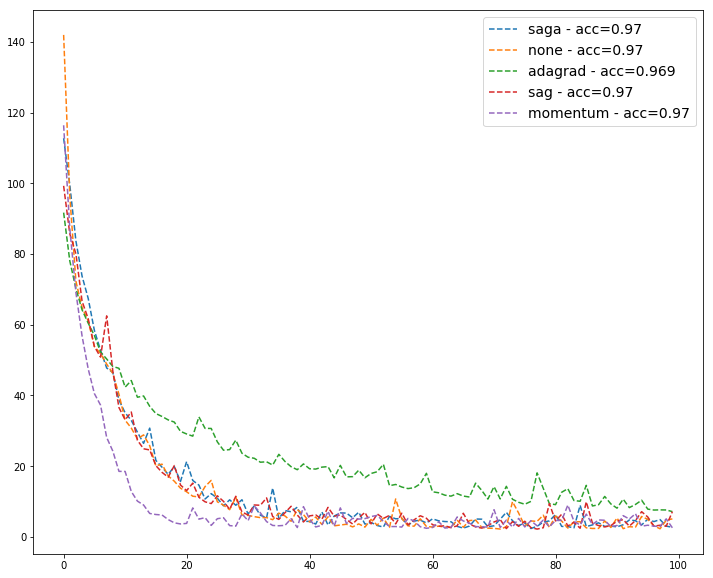

In [30]:
fig = plt.figure(figsize=(12,10))
for clf in classifiers.items():
    plt.plot(np.arange(len(clf[1].f_history)), clf[1].f_history, '--', label=clf[0] + " - acc=" + str(round(clf[1].accuracy, 3)))
plt.legend(fontsize=14)
plt.show()

Letting aside the disapointing performance of the adagrad method for this dataset, none of the acceleration strategies tested outstands the others.
Each method should be tested on a range of parameters (regularisation coefficient, momentum, learning rate...) in order to eventually select the most performing one. In the next part we'll do it only for the momentum acceleration strategy (the fastest one to decrease here).

We also notice that accuracies are also very similar, a deeper dive into the AUC score for instance could give more insight on their actual performance

### Regularisation coefficient

In [50]:
alpha_range = [1e-2, 1, 5, 10]

In [51]:
regul_clf = {alpha: LogisticRegression(alpha=alpha, 
                                            bsize=100, 
                                            acceleration='momentum') for alpha in alpha_range}

In [58]:
np.random.seed(171)
random.seed(171)

for clf in regul_clf.values():
    clf.fit(X_train, y_train)
    clf.score(X_test, y_test)

Training done
Training done
Training done
Training done


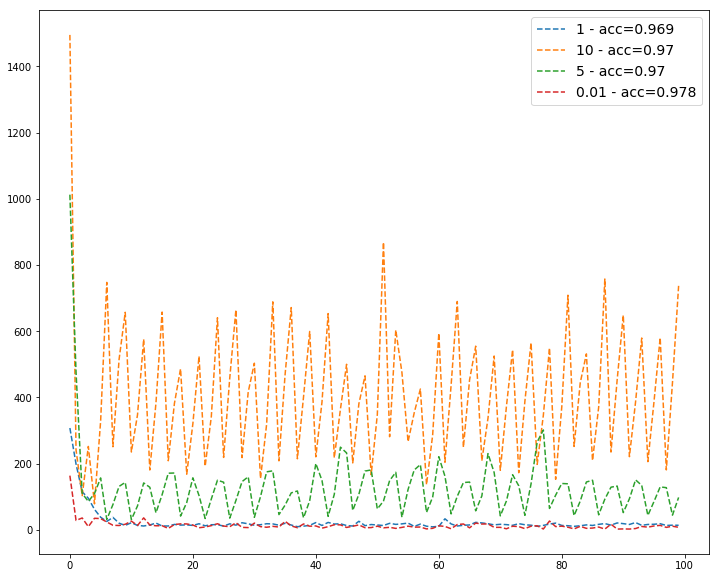

In [59]:
fig = plt.figure(figsize=(12,10))
for clf in regul_clf.items():
    plt.plot(np.arange(len(clf[1].f_history)), clf[1].f_history, '--', label=str(clf[0]) + " - acc=" + str(round(clf[1].accuracy, 3)))
plt.legend(fontsize=14)
plt.show()

- When $\alpha >1$, gradient descent becomes disapointing, step size gets too large and so does the reachable exploration area
- Decreases slightly faster for $\alpha=0.01$ but no significant improvement
- Accuracy still not affected

### Momentum

We will try several momentum values:
- $\theta_{t}\in\{0.01,0.1,1,2,8\}$

In [64]:
theta_range = [1e-8, 1e-4, 1e-2, 2, 80]

In [65]:
momentum_clf = {theta: LogisticRegression(alpha=0.5, 
                                          bsize=100, 
                                          acceleration='momentum',
                                          momentum = theta) for theta in theta_range}

In [66]:
np.random.seed(101)
random.seed(101)

for clf in momentum_clf.values():
    clf.fit(X_train, y_train)
    clf.score(X_test, y_test)

Training done
Training done
Training done
Training done
Training done


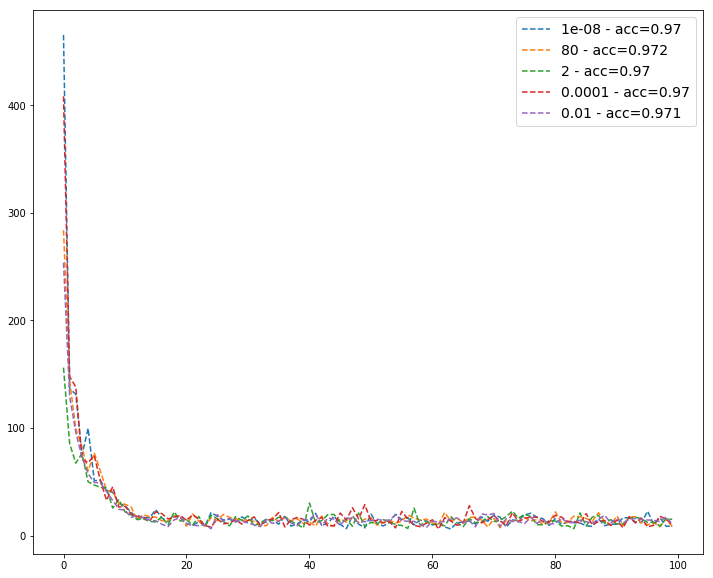

In [67]:
fig = plt.figure(figsize=(12,10))
for clf in momentum_clf.items():
    plt.plot(np.arange(len(clf[1].f_history)), clf[1].f_history, '--', label=str(clf[0]) + " - acc=" + str(round(clf[1].accuracy, 3)))
plt.legend(fontsize=14)
plt.show()

- Truly doesn't seem to affect much the gradient descent here

# Answers : 2. Bacth and online solutions

#### Question 1

By computing the gradient, we obtain : 
    
$$ \nabla L(\textbf{w}) =  \nabla F(\textbf{w}) + \nabla R(\textbf{w}) = \sum_{i=1}^{n}\frac{-y_{i}e^{-y_{i}\textbf{w}^{T}\textbf{x}_{i}}}{1+e^{-y_{i}\textbf{w}^{T}\textbf{x}_{i}}} + \lambda\textbf{w}$$

#### Question 2

The ridge regularization penalizes the coefficients of $\textbf{w}$ following : 

$$\textbf{w}_{\mathcal{l}_{2}} = \frac{1}{1+\lambda}\textbf{w}$$

So $\lambda$ is high enough, noise would be reduced compared to actual meaningfull features. We can hence focus on the most relevant features to learn the model and improve performances 

#### Question 3

Let $f_{i}(\textbf{w})= log(1+\exp(-y_i\textbf{w}^Tx_i)), \forall\textbf{w}\in\mathbb{R}^{d}, \forall{i}\in\{1,...,n\}$

Then, $F(\textbf{w}) = \sum_{i=1}^{n}f_{i}(\textbf{w})$

Hence, if we compute $\nabla f_{i}$ for each row and sum them all we would get $\nabla F$

#### Question 4

As in previous question, if we compute $\nabla F_{j}$ for each batch and sum them all we would get $\nabla F$

We can also assume that the batches gradients computed would globally lead us to the same direction than the global gradient and hence use $\nabla F_{j}$ at each iteration with a different random batch.

See above notebook for implementation

#### Question 5

See above notebook for implementation